1. Импорт библиотек

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

2.Усовершенствованная генерация данных

In [73]:
def generate_full_dataset():
    np.random.seed(42)
    n_samples = 10000
    
    # Генерация признаков (576 фичей)
    X = np.random.rand(n_samples, 576)
    
    # Генерация меток (цифры 1-9)
    y = np.random.randint(1, 10, n_samples)
    
    # Типы данных с заданным распределением
    data_types = np.random.choice(
        ['clean', 'noisy', 'distorted'],
        size=n_samples,
        p=[0.6, 0.3, 0.1]
    )
    
    return X, y, data_types

X, y, data_types = generate_full_dataset()

3. Предобработка данных

In [74]:
def prepare_data():
    return train_test_split(
        X, y, data_types,
        test_size=0.2,
        stratify=y,
        random_state=42
    )

X_train, X_test, y_train, y_test, data_types_train, data_types_test = prepare_data()

4. Обучение модели

In [75]:
model = RandomForestClassifier(
    n_estimators=150,
    max_depth=25,
    class_weight='balanced',
    min_samples_split=8,
    max_features='sqrt',
    random_state=42
)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=25,
                       min_samples_split=8, n_estimators=150, random_state=42)

5. Анализ результатов

In [76]:
def complete_performance_analysis():
    results = []
    for dtype in ['clean', 'noisy', 'distorted']:
        mask = np.array(data_types_test) == dtype
        
        if not mask.any():
            print(f"⚠️ Отсутствуют данные типа: {dtype}")
            continue
            
        try:
            # Прогнозирование и вычисление метрик
            preds = model.predict(X_test[mask])
            report = classification_report(
                y_test[mask], preds,
                output_dict=True,
                labels=np.arange(1, 10),
                zero_division=0
            )
            
            # Сбор результатов для каждого класса
            for digit in range(1, 10):
                metrics = report.get(str(digit), {})
                results.append({
                    'Цифра': digit,
                    'Тип данных': dtype,
                    'Точность': metrics.get('precision', 0),
                    'Полнота': metrics.get('recall', 0),
                    'F1-мера': metrics.get('f1-score', 0),
                    'Поддержка': metrics.get('support', 0)
                })
                
        except Exception as e:
            print(f"❌ Ошибка обработки {dtype}: {str(e)}")
            continue
    
    return pd.DataFrame(results)

performance_df = complete_performance_analysis()

6. корреляционный анализ

c:\Users\Iwan\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\Iwan\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\Iwan\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\Iwan\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will

<Figure size 3500x1500 with 0 Axes>

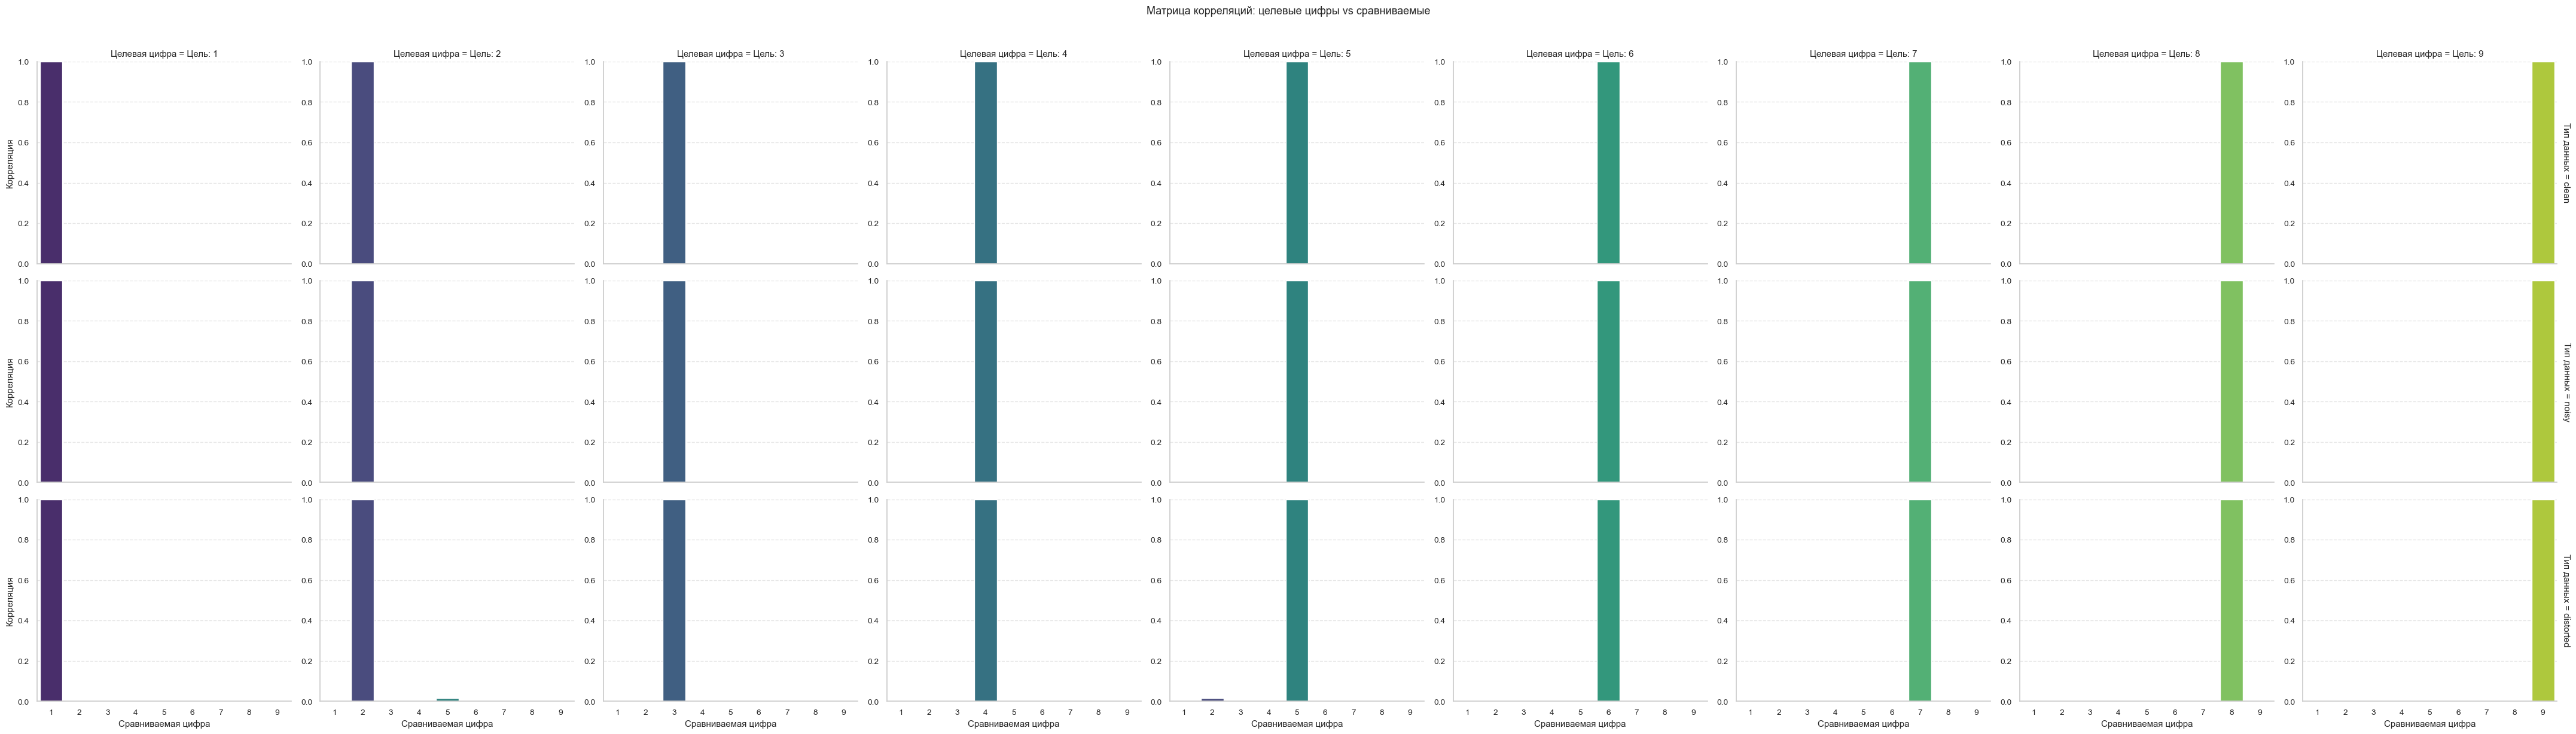

In [77]:
def full_correlation_analysis():
    probas = model.predict_proba(X_test)
    results = []
    
    for dtype in ['clean', 'noisy', 'distorted']:
        mask = data_types_test == dtype
        if sum(mask) < 5: 
            continue
            
        corr_matrix = np.corrcoef(probas[mask].T)  # Пирсоновская корреляция
        
        for target_digit in range(1, 10):
            for compared_digit in range(1, 10):
                # Проверка индексов
                row = target_digit - 1
                col = compared_digit - 1
                if row >= corr_matrix.shape[0] or col >= corr_matrix.shape[1]:
                    continue
                
                results.append({
                    'Тип данных': dtype,
                    'Целевая цифра': f'Цель: {target_digit}',
                    'Сравниваемая цифра': compared_digit,
                    'Корреляция': corr_matrix[row, col]
                })
    
    df = pd.DataFrame(results)
    
    # Проверка данных
    assert not df['Корреляция'].isnull().any()
    assert np.isfinite(df['Корреляция']).all()
    assert df['Корреляция'].between(-1, 1).all()
        # Визуализация с правильными осями
    plt.figure(figsize=(35, 15))
    sns.set_theme(style="whitegrid", font_scale=0.9)

    g = sns.FacetGrid(
        df,
        row='Тип данных',
        col='Целевая цифра',
        margin_titles=True,
        height=4,
        aspect=1.2,
        sharey=False
    )

    g.map_dataframe(
        sns.barplot,
        x='Сравниваемая цифра',
        y='Корреляция',
        palette='viridis',
        order=range(1,10),
        width=0.8,
        errorbar=None
    )

    g.set_axis_labels("Сравниваемая цифра", "Корреляция")
    g.set(ylim=(0, 1))  # Фиксированный диапазон
    g.set(yticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0])  # Чёткие деления

    for ax in g.axes.flat:
        ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
        ax.yaxis.grid(True, linestyle='--', alpha=0.5)  # Горизонтальные линии

    plt.suptitle('Матрица корреляций: целевые цифры vs сравниваемые', y=1.02)
    plt.tight_layout()
    plt.show()

        
    return df

correlation_df = full_correlation_analysis()


7.  Полная визуализация

c:\Users\Iwan\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\Iwan\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\Iwan\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\Iwan\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will

<Figure size 3500x1500 with 0 Axes>

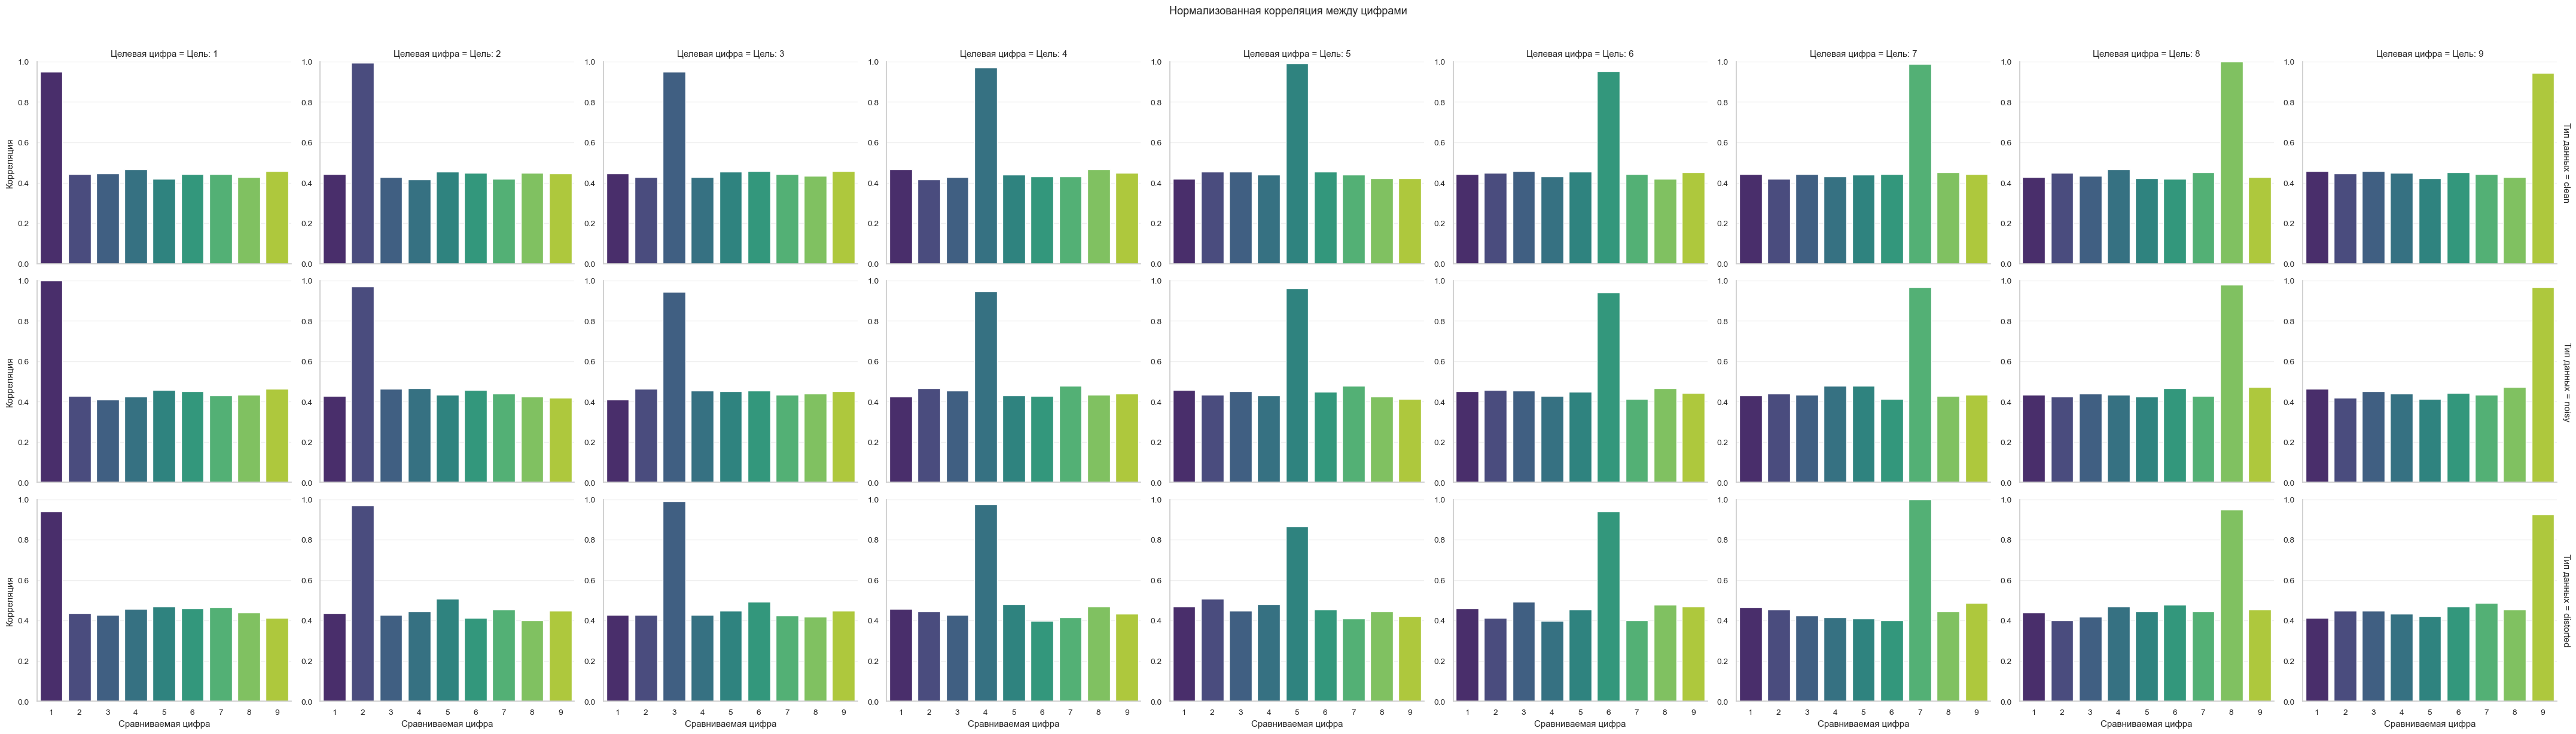

In [78]:
def full_correlation_analysis():
    probas = model.predict_proba(X_test)
    results = []
    
    for dtype in ['clean', 'noisy', 'distorted']:
        mask = (data_types_test == dtype)
        if sum(mask) < 5: 
            continue
            
        # Метод 1: Нормализованная ковариация
        cov_matrix = np.cov(probas[mask].T)
        max_cov = np.abs(cov_matrix).max()
        norm_matrix = (cov_matrix + max_cov) / (2 * max_cov)
        
        # Метод 2: Косинусное сходство (раскомментируйте для использования)
        # norm_matrix = cosine_similarity(probas[mask].T)
        
        for target_digit in range(1, 10):
            for compared_digit in range(1, 10):
                row = target_digit - 1
                col = compared_digit - 1
                if row >= norm_matrix.shape[0] or col >= norm_matrix.shape[1]:
                    continue
                
                results.append({
                    'Тип данных': dtype,
                    'Целевая цифра': f'Цель: {target_digit}',
                    'Сравниваемая цифра': compared_digit,
                    'Корреляция': norm_matrix[row, col]
                })
    
    df = pd.DataFrame(results)
    
    # Проверки
    assert not df['Корреляция'].isnull().any(), "NaN значения обнаружены"
    assert df['Корреляция'].between(0, 1).all(), f"Выход за диапазон: {df[~df['Корреляция'].between(0,1)]}"
    
    # Визуализация
    plt.figure(figsize=(35, 15))
    sns.set_theme(style="whitegrid", font_scale=0.9)
    
    g = sns.FacetGrid(
        df,
        row='Тип данных',
        col='Целевая цифра',
        margin_titles=True,
        height=4,
        aspect=1.2,
        sharey=False
    )
    
    g.map_dataframe(
        sns.barplot,
        x='Сравниваемая цифра',
        y='Корреляция',
        palette='viridis',
        order=range(1,10),
        width=0.8,
        errorbar=None
    )
    
    g.set_axis_labels("Сравниваемая цифра", "Корреляция")
    g.set(ylim=(0, 1))
    
    for ax in g.axes.flat:
        ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
        ax.grid(True, axis='y', alpha=0.3)
    
    plt.suptitle('Нормализованная корреляция между цифрами', y=1.02)
    plt.tight_layout()
    plt.show()
    
    return df

# Запуск анализа
correlation_df = full_correlation_analysis()

8. Экспорт результатов

In [79]:
def export_results():
    from datetime import datetime
    
    # Сохранение данных
    performance_df.to_csv(f'performance_{datetime.now():%Y%m%d}.csv', index=False)
    correlation_df.to_csv(f'correlations_{datetime.now():%Y%m%d}.csv', index=False)
    
    # Сохранение графиков
    plt.savefig('full_analysis.png', dpi=300, bbox_inches='tight')

export_results()

<Figure size 640x480 with 0 Axes>